In [77]:
%reload_ext autoreload

# import packages
import numpy as np
import pandas as pd

import warnings # for supressing a warning when importing large files
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# !pip install simple-venn
from simple_venn import venn2, venn3, venn4 # for charting venn diagrams
from itertools import combinations


# import own scripts
import sys
sys.path.insert(0, '/healthcare-fraud/src/')

%autoreload 2
import scripts as src

# Exploring the Data (EDA)
---
> **LEIE**: The Office of the Inspector General's (OIG) `List of Excluded Individuals/Entities` (LEIE) provides information to the health care industry, patients and the public regarding individuals and entities currently excluded from participation in Medicare, Medicaid and all other Federal health care programs.
>
> **PartD**: The Part D Prescriber `Public Use File` (PUF) provides information on `prescription drugs` prescribed by individual physicians and other health care providers and paid for under the Medicare Part D Prescription Drug Program. 

### LEIE
---

In [3]:
# import data
LEIE = src.read_from_efs('raw_LEIE.csv').reset_index(drop=True)
src.print_info(LEIE, 'LEIE')
LEIE.tail()

LEIE pd.DataFrame shape: (70056, 18)
LEIE pd.DataFrame size: 10.09 Mb


,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
70051,ZWOLINSKI,RUSSELL,K,NaN,"MEDICAL PRACTICE, MD",SURGERY,G25488,0,19670330.0,1728 W WINNEMAC AVE,CHICAGO,IL,60618,1128b4,20031020,0,0,NaN
70052,ZYDERVELD,MARY,ANN,NaN,PHARMACY,TECHNICIAN,NaN,0,19520825.0,1358 MORNING GLORY TURN,RUCKERSVILLE,VA,22962,1128b4,20090219,0,0,NaN
70053,ZYLSTRA,CHRISTEENA,LYNN,NaN,NURSING PROFESSION,NURSE/NURSES AIDE,NaN,0,19670724.0,1816 NE 49TH STREET,KANSAS CITY,MO,64118,1128b4,20100318,0,0,NaN
70054,ZYLSTRA,JAMES,PETER,NaN,REHAB FACILITY - GEN,EMPLOYEE,NaN,0,19550420.0,"2305 MINNESOTA BLVD, S E",ST CLOUD,MN,56304,1128a2,20040920,0,0,NaN
70055,ZYWOCINSKI,CYNTHIA,A,NaN,OSTEOPATHIC PRAC,OSTEOPATHY,F00244,0,19630316.0,117 WHITE TAIL LANE,LANCASTER,MA,1523,1128b14,19990720,0,0,NaN


### Part - D
---

In [4]:
PartD = src.read_from_efs('raw_PartD.csv').reset_index(drop=True)
src.print_info(PartD, 'PartD')
PartD.tail()

PartD pd.DataFrame shape: (97259508, 22)
PartD pd.DataFrame size: 17117.67 Mb


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,year
97259503,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,LAMOTRIGINE,LAMOTRIGINE,NaN,...,367,108.87,0.0,NaN,0.0,NaN,0.0,0.0,0.0,2016
97259504,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,QUETIAPINE FUMARATE,QUETIAPINE FUMARATE,NaN,...,426,360.38,0.0,NaN,0.0,NaN,0.0,0.0,0.0,2016
97259505,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,RISPERIDONE,RISPERIDONE,NaN,...,432,172.30,NaN,*,NaN,*,NaN,NaN,NaN,2016
97259506,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,SERTRALINE HCL,SERTRALINE HCL,13.0,...,640,110.68,NaN,*,NaN,*,NaN,NaN,NaN,2016
97259507,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,TRAZODONE HCL,TRAZODONE HCL,16.0,...,632,209.33,NaN,*,NaN,*,NaN,NaN,NaN,2016


<br>
<br>
<br>
## Match-up records
---
> 1. by National Provider Identifier, `NPI`
> 2. by `full name`, which will include putting together:
    - first name
    - last name
    - specialty
    - city
    

### Matching by `NPI`
---

In [6]:
NPI_df = src.get_intersection_by_npi(LEIE, PartD)
src.print_info(NPI_df, 'NPI_df')
NPI_df.tail()

NPI_df pd.DataFrame shape: (1148, 4)
NPI_df pd.DataFrame size: 0.04 Mb


,NPI,EXCLTYPE,EXCLDATE,REINDATE
1143,1285742619,1128a1,20160320,0
1144,1891879003,1128b4,20160218,0
1145,1871523852,1128a4,20161020,0
1146,1558366815,1128a1,20160320,0
1147,1174561708,1128b4,20161220,0


In [82]:
NPI_counts = src.get_NPI_counts(PartD, LEIE)
NPI_counts

,Count
Participating healthcare providers in Medicare Part D,1075934
Excluded healthcare providers since 2014 with an NPI,2843
Total matches by NPI,1079


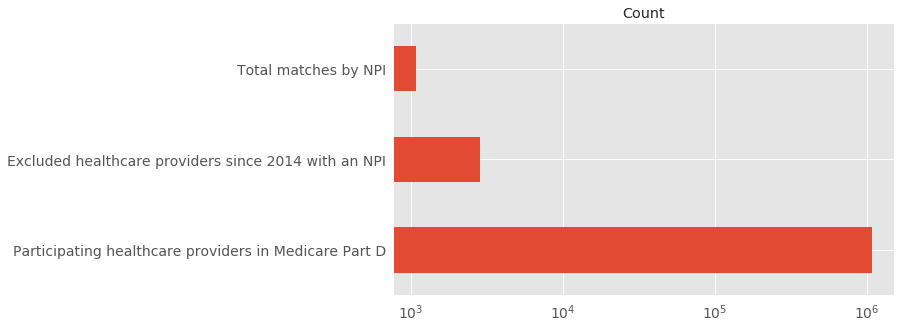

In [81]:
src.bar_plot_NPI_count(NPI_counts)

### Matching by full-name using `fuzzy-wuzzy`
---
> Although, over 25M pairs were compared the results **do not** have a signigificant contribution to address `unbalanced classes` issue. Therefore, **Fuzzy-wuzzy results are not included in the model!**

In [86]:
fuzzy = src.read_from_efs('fuzz_matches_df.csv')
src.print_info(fuzzy, 'fuzzy')
fuzzy.head(10)

fuzzy pd.DataFrame shape: (398, 10)
fuzzy pd.DataFrame size: 0.04 Mb


,Qratio,UQratio,UWQratio,WRatio,partial_ratio,partial_token_sort_ratio,token_set_ratio,token_sort_ratio,LEIE,PartD
0,96,96,96,96,66,91,96,96,MECHANIC JEFFREY COUNSELOR NEW YORK,MECHANIC JEFF Counselor NEW YORK
1,96,96,96,96,75,96,96,96,GREICO JAMES DENTIST CHICAGO,GRIECO JAMES Dentist CHICAGO
2,92,92,92,92,75,81,92,79,SAVAGE ROBERT DENTIST HARRISBURG,NAGLE ROBERT Dentist HARRISBURG
3,91,91,91,91,67,85,91,91,GREICO JAMES DENTIST CHICAGO,GORIL JAMES Dentist CHICAGO
4,90,90,90,90,70,87,93,90,GENNA STEPHEN DENTIST LONG BEACH,LEE STEPHEN Dentist LONG BEACH
5,90,90,90,90,73,89,90,90,SULLIVAN PATRICIA DENTIST GAINESVILLE,SHIPMAN PATRICIA Dentist GAINESVILLE
6,89,89,89,89,68,86,86,86,TRAN THUAN DENTIST HENDERSON,TANG THIEN Dentist HENDERSON
7,89,89,89,89,66,80,91,82,SANTIAGO JEANINE GENERAL PRACTICE FISHKILL,SANTIAGO JEANINE Family Practice FISHKILL
8,89,89,89,89,67,88,91,89,CARRILLO PEDRO GENERAL PRACTICE BAKERSFIELD,CARRILLO PEDRO Family Practice BAKERSFIELD
9,89,89,89,89,71,87,91,89,GENNA STEPHEN DENTIST LONG BEACH,KEEL STEPHEN Dentist LONG BEACH


## Conclusions on EDA:
> 1. `Unbalanced Classes` is likely going to be major hurdle
> 2. `Big Data`: crunching 20 Gigs of data at a time is not feasable on any available local machines. **AWS to the rescue!!!**
---
---


<br>
<br>
<br>
# Feature Engineering to address `Unbalanced Classes` and `Big Data` using:
---
> 1. Logical and Sensible methods
> 2. Over/Under sampling and other Machine Learning techniques in **Part 2**

In [88]:
PartD_excl = PartD[PartD['npi'].isin(NPI_df['NPI'])].drop_duplicates().reset_index(drop=True)
print('PartD_excl shape: ', PartD_excl.shape)
PartD_excl.tail()

PartD_excl shape:  (121096, 22)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,year
121091,1982782900,EVANS,RICHARD,HOUSTON,TX,Physical Medicine and Rehabilitation,S,MELOXICAM,MELOXICAM,NaN,...,840,90.56,NaN,*,NaN,*,NaN,NaN,NaN,2016
121092,1982782900,EVANS,RICHARD,HOUSTON,TX,Physical Medicine and Rehabilitation,S,OXYCODONE HCL,OXYCODONE HCL,NaN,...,1284,3857.25,0.0,NaN,0.0,NaN,0.0,0.0,0.00,2016
121093,1982782900,EVANS,RICHARD,HOUSTON,TX,Physical Medicine and Rehabilitation,S,OXYCONTIN,OXYCODONE HCL,NaN,...,435,7663.38,0.0,NaN,0.0,NaN,0.0,0.0,0.00,2016
121094,1982782900,EVANS,RICHARD,HOUSTON,TX,Physical Medicine and Rehabilitation,S,TIZANIDINE HCL,TIZANIDINE HCL,NaN,...,510,305.07,NaN,*,17.0,NaN,17.0,510.0,305.07,2016
121095,1992720700,BEAUMONT,GRAHAM,SAN MATEO,CA,Psychiatry & Neurology,T,OLANZAPINE,OLANZAPINE,NaN,...,516,257.64,0.0,NaN,0.0,NaN,0.0,0.0,0.00,2016


In [ ]:
PartD_ok = PartD[~PartD['npi'].isin(common_npi)].drop_duplicates().reset_index(drop=True)
PartD_ok['EXCLTYPE'] = np.nan
PartD_ok['EXCLDATE'] = np.nan
PartD_ok['REINDATE'] = np.nan

print('PartD_ok shape: ', PartD_ok.shape)
PartD_ok.tail()

In [ ]:
def populate_exclusions(excl_npi):
    return LEIE_clean[['EXCLTYPE','EXCLDATE','REINDATE']][LEIE_clean['NPI'] == excl_npi].values.tolist()[0]

In [ ]:
print("Number of available CPU cores: ")
!cat /proc/cpuinfo | grep processor | wc -l

In [ ]:
from multiprocessing import Pool
!pip install tqdm
from tqdm import tqdm_notebook
import itertools

# find target indeces for target drugs using multiprocessing
processors = 64
if __name__ == '__main__':
    tasks = PartD_excl['npi']
    function = populate_exclusions
    with Pool(processes=processors)as p:
        results = list(tqdm_notebook(p.imap(function, tasks), total=len(tasks)))



In [ ]:
PartD_excl['EXCLTYPE'] = np.array(results).T[0]
PartD_excl['EXCLDATE'] = np.array(results).T[1]
PartD_excl['REINDATE'] = np.array(results).T[2]

In [ ]:
PartD_excl['label'] = PartD_excl['year']<= pd.to_datetime(PartD_excl["EXCLDATE"], format="%Y%m%d").dt.year
PartD_ok['label'] = False

In [ ]:
PartD_ok.head()

In [ ]:
df = pd.concat([PartD_excl, PartD_ok], axis=0).sort_values(['year','npi']).reset_index(drop=True)
df.shape

In [ ]:
df.tail()

## Compare between `excluded` and  `not excluded` prescribers `apples to apples`
---
> 1. consider records only by common `specialty_description`and
> 2. by common `generic_name`

In [ ]:
trgt_specialties = set(df['specialty_description'][df['label'] == True])
trgt_drugs = set(df['generic_name'][df['label'] == True])

In [ ]:
df_trgt = df[(df['specialty_description'].isin(trgt_specialties))&\
             (df['generic_name'].isin(trgt_drugs))].reset_index(drop=True)
df_trgt.tail()

In [ ]:
src.save_to_efs(df_trgt, 'df_trgt.csv')